# 📝 Trabajo Final - Modelos de Procesamiento de Lenguaje Natural
## Parte 4: Análisis de Texto y Modelos Híbridos

**Maestría en Economía Aplicada - UBA**  
**Dataset:** Inmuebles filtrado y optimizado + Descripción de texto

---


## 📚 Librerías e Importaciones


In [40]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Librerías específicas para NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import re
import string
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Librerías cargadas correctamente")
print("📝 Configuración NLP lista")


✅ Librerías cargadas correctamente
📝 Configuración NLP lista


## 📊 Carga de Datos y Análisis Exploratorio de Texto


In [41]:
# Cargar dataset filtrado y optimizado desde notebook 01
df = pd.read_csv('train_bi_2025_filtered.csv')
print("✅ Dataset filtrado y optimizado cargado")
print(f"📊 Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

# Análisis exploratorio de la variable description
print(f"\n📝 ANÁLISIS EXPLORATORIO DE TEXTO:")
print("=" * 50)

if 'description' in df.columns:
    print(f"✅ Variable 'description' encontrada")
    
    # Estadísticas básicas del texto
    df['description_length'] = df['description'].astype(str).apply(len)
    df['description_words'] = df['description'].astype(str).apply(lambda x: len(x.split()))
    
    print(f"📋 Estadísticas de descripción:")
    print(f"   • Textos no nulos: {df['description'].notna().sum():,} ({df['description'].notna().mean():.1%})")
    print(f"   • Textos nulos:    {df['description'].isna().sum():,} ({df['description'].isna().mean():.1%})")
    print(f"   • Longitud promedio: {df['description_length'].mean():.0f} caracteres")
    print(f"   • Palabras promedio: {df['description_words'].mean():.0f} palabras")
    print(f"   • Longitud mediana:  {df['description_length'].median():.0f} caracteres")
    
    # Reemplazar valores nulos por string vacío
    df['description'] = df['description'].fillna('')
    
    # Mostrar ejemplos de descripciones
    print(f"\n📋 EJEMPLOS DE DESCRIPCIONES:")
    print("=" * 40)
    sample_descriptions = df[df['description'].str.len() > 50]['description'].head(3)
    for i, desc in enumerate(sample_descriptions, 1):
        print(f"{i}. {desc[:150]}...")
        
else:
    print("❌ Variable 'description' no encontrada")
    print("   Se procederá solo con variables numéricas/categóricas")
    df['description'] = ''

# Verificar tipos de datos
print(f"\n🔍 TIPOS DE VARIABLES:")
print("=" * 30)
for dtype in df.dtypes.value_counts().items():
    print(f"   {dtype[0]}: {dtype[1]} variables")

print(f"✅ Dataset listo para modelado NLP")


✅ Dataset filtrado y optimizado cargado
📊 Dimensiones: 311,660 filas × 15 columnas

📝 ANÁLISIS EXPLORATORIO DE TEXTO:
✅ Variable 'description' encontrada
📋 Estadísticas de descripción:
   • Textos no nulos: 311,660 (100.0%)
   • Textos nulos:    0 (0.0%)
   • Longitud promedio: 935 caracteres
   • Palabras promedio: 143 palabras
   • Longitud mediana:  745 caracteres

📋 EJEMPLOS DE DESCRIPCIONES:
1. Apto crédito PH en PB de 4 ambientes al frente Superficie total de 73m² cubierta de 57m² y descubierta de 16m² Tres dormitorios un baño completo Livin...
2. Excelente 3 ambientes ubicado en una de las mejores zonas de Capital Federal en el barrio de Colegiales El mismo cuenta con un amplio living comedor c...
3. Corredor Responsable Matias Castelli  CUCICBA 3678  CMCPSI 6099Contacto Florencia Melamed  MLS ID  42009114960Venta Departamento de 3 ambientes Todo r...

🔍 TIPOS DE VARIABLES:
   int64: 9 variables
   float64: 4 variables
   object: 4 variables
✅ Dataset listo para modelado NLP


## 🔧 Preprocesamiento de Texto

In [42]:
# Preprocesamiento de texto en español
print("🔧 PREPROCESAMIENTO DE TEXTO")
print("=" * 40)

def clean_spanish_text(text):
    """
    Limpia texto en español para análisis NLP
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convertir a string y minúsculas
    text = str(text).lower()
    
    # Remover caracteres especiales pero mantener acentos
    text = re.sub(r'[^\w\sáéíóúüñ]', ' ', text)
    
    # Remover números
    text = re.sub(r'\d+', '', text)
    
    # Remover espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    
    # Quitar espacios al inicio y final
    text = text.strip()
    
    return text

# Aplicar limpieza de texto
print("⏳ Limpiando textos...")
df['description_clean'] = df['description'].apply(clean_spanish_text)

# Palabras vacías en español (básicas)
spanish_stopwords = {
    # Artículos y preposiciones
    'el', 'la', 'los', 'las', 'un', 'una', 'de', 'del', 'al', 
    # Conjunciones y conectores
    'y', 'o', 'pero', 'que', 'si', 'como', 'cuando', 'donde', 'no',
    # Pronombres
    'se', 'te', 'lo', 'le', 'su', 'sus', 'me', 'mi', 'tu',
    # Verbos comunes
    'es', 'son', 'está', 'están', 'tiene', 'tienen', 'puede', 'pueden',
    # Adverbios genéricos
    'muy', 'más', 'bien', 'todo', 'todos', 'hasta', 'desde',
    # Preposiciones
    'en', 'a', 'por', 'con', 'para', 'sin', 'sobre', 'entre'
}

# Estadísticas después de limpieza
df['description_clean_length'] = df['description_clean'].apply(len)
df['description_clean_words'] = df['description_clean'].apply(lambda x: len(x.split()) if x else 0)

print(f"✅ Limpieza completada:")
print(f"   • Longitud promedio (limpio): {df['description_clean_length'].mean():.0f} caracteres")
print(f"   • Palabras promedio (limpio):  {df['description_clean_words'].mean():.0f} palabras")
print(f"   • Textos vacíos después limpieza: {(df['description_clean_length'] == 0).sum():,}")

# Mostrar ejemplos de texto limpio
print(f"\n📋 EJEMPLOS DE TEXTO LIMPIO:")
print("=" * 35)
sample_clean = df[(df['description_clean_length'] > 30) & (df['description_clean_length'] < 100)]['description_clean'].head(3)
for i, desc in enumerate(sample_clean, 1):
    print(f"{i}. {desc}")

print(f"\n✅ Preprocesamiento completado")


🔧 PREPROCESAMIENTO DE TEXTO
⏳ Limpiando textos...
✅ Limpieza completada:
   • Longitud promedio (limpio): 895 caracteres
   • Palabras promedio (limpio):  136 palabras
   • Textos vacíos después limpieza: 0

📋 EJEMPLOS DE TEXTO LIMPIO:
1. consultas atención personalizada larocca propiedades
2. monoambiente al frente con balcon posibilidad de cochera a bcosto
3. yacopino inmobiliarias mas de años de honestidad profesional

✅ Preprocesamiento completado


## 📊 Preparación de Datos Híbridos (Texto + Numérico)


In [43]:
# Preparación de datos híbridos (texto + numérico/categórico) - CORREGIDA
print("📊 PREPARACIÓN DE DATOS HÍBRIDOS")
print("=" * 45)

def prepare_hybrid_data(df):
    """
    Prepara datos combinando features tradicionales + texto
    """
    df_model = df.copy()
    
    # Variables a excluir
    exclude_vars = ['price', 'lat', 'lon', 'description', 'description_length', 
                   'description_words', 'description_clean_length', 'description_clean_words',
                   'description_clean']  # ← ✅ AGREGAMOS description_clean aquí
    
    # Features tradicionales (numéricas + categóricas) - SIN description_clean
    X_traditional = df_model.drop(columns=exclude_vars, errors='ignore')
    
    # Variable de texto limpia (procesada por separado)
    X_text = df_model['description_clean']
    
    # Variable objetivo
    y = df_model['price']
    
    # Procesar variables categóricas en features tradicionales
    categorical_vars = X_traditional.select_dtypes(include=['object']).columns.tolist()
    numerical_vars = X_traditional.select_dtypes(exclude=['object']).columns.tolist()
    
    print(f"🔢 Features tradicionales:")
    print(f"   • Variables numéricas: {len(numerical_vars)}")
    print(f"   • Variables categóricas: {len(categorical_vars)}")
    
    # Verificar variables categóricas
    for var in categorical_vars:
        n_unique = X_traditional[var].nunique()
        print(f"     - {var}: {n_unique:,} categorías")
    
    # Convertir categóricas a dummies (ahora seguro)
    if len(categorical_vars) > 0:
        X_cat_encoded = pd.get_dummies(X_traditional[categorical_vars], drop_first=True)
        X_traditional_final = pd.concat([X_traditional[numerical_vars], X_cat_encoded], axis=1)
        print(f"   • Variables categóricas convertidas a {X_cat_encoded.shape[1]} dummies")
    else:
        X_traditional_final = X_traditional
    
    print(f"   • Total features tradicionales: {X_traditional_final.shape[1]}")
    
    # Información del texto
    non_empty_text = (X_text.str.len() > 0).sum()
    print(f"📝 Features de texto:")
    print(f"   • Textos no vacíos: {non_empty_text:,} ({non_empty_text/len(X_text):.1%})")
    print(f"   • Textos procesados por separado con TF-IDF")
    
    return X_traditional_final, X_text, y

# Preparar datos
X_traditional, X_text, y = prepare_hybrid_data(df)

# División train/test manteniendo la consistencia
X_trad_train, X_trad_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_traditional, X_text, y, test_size=0.2, random_state=42
)

print(f"\n📊 DIVISIÓN DE DATOS:")
print("=" * 30)
print(f"Entrenamiento: {len(X_trad_train):,} muestras")
print(f"Prueba:        {len(X_trad_test):,} muestras")
print(f"Features tradicionales: {X_trad_train.shape[1]}")
print(f"Features de texto: 1 (description_clean)")

# Estandarización de features tradicionales
scaler = StandardScaler()
X_trad_train_scaled = scaler.fit_transform(X_trad_train)
X_trad_test_scaled = scaler.transform(X_trad_test)

print(f"\n✅ Datos preparados para modelos híbridos:")
print(f"   • Features tradicionales estandarizadas: {X_trad_train_scaled.shape}")
print(f"   • Features de texto listas: {len(X_text_train):,} descripciones")

📊 PREPARACIÓN DE DATOS HÍBRIDOS
🔢 Features tradicionales:
   • Variables numéricas: 8
   • Variables categóricas: 3
     - l2: 5 categorías
     - l3: 73 categorías
     - prop_type: 10 categorías
   • Variables categóricas convertidas a 85 dummies
   • Total features tradicionales: 93
📝 Features de texto:
   • Textos no vacíos: 311,660 (100.0%)
   • Textos procesados por separado con TF-IDF

📊 DIVISIÓN DE DATOS:
Entrenamiento: 249,328 muestras
Prueba:        62,332 muestras
Features tradicionales: 93
Features de texto: 1 (description_clean)

✅ Datos preparados para modelos híbridos:
   • Features tradicionales estandarizadas: (249328, 93)
   • Features de texto listas: 249,328 descripciones


## 🔤 Extracción de Features de Texto con TF-IDF


In [44]:
# Extracción de features de texto usando TF-IDF
print("🔤 EXTRACCIÓN DE FEATURES TF-IDF")
print("=" * 40)

# Configurar TF-IDF para español
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,  # Limitar features para eficiencia
    min_df=5,          # Palabra debe aparecer en al menos 5 documentos
    max_df=0.8,        # Palabra no puede aparecer en más del 80% de documentos
    ngram_range=(1, 2), # Unigramas y bigramas
    stop_words=list(spanish_stopwords),  # Palabras vacías en español
    lowercase=True,
    strip_accents=None  # Mantener acentos para español
)

print("⏳ Extrayendo features TF-IDF...")
print(f"   • Configuración: max_features=500, ngram_range=(1,2)")
print(f"   • Stop words: {len(spanish_stopwords)} palabras vacías")

# Ajustar TF-IDF en datos de entrenamiento
X_text_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
X_text_tfidf_test = tfidf_vectorizer.transform(X_text_test)

print(f"✅ Features TF-IDF extraídas:")
print(f"   • Train shape: {X_text_tfidf_train.shape}")
print(f"   • Test shape:  {X_text_tfidf_test.shape}")
print(f"   • Vocabulario: {len(tfidf_vectorizer.vocabulary_):,} términos únicos")
print(f"   • Densidad promedio: {X_text_tfidf_train.nnz / (X_text_tfidf_train.shape[0] * X_text_tfidf_train.shape[1]):.1%} (matriz esparsa)")

# Términos más frecuentes
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_text_tfidf_train.mean(axis=0).A1
top_terms_idx = tfidf_scores.argsort()[-20:][::-1]

print(f"\n🔝 TOP 20 TÉRMINOS MÁS IMPORTANTES:")
print("=" * 45)
for i, idx in enumerate(top_terms_idx, 1):
    term = feature_names[idx]
    score = tfidf_scores[idx]
    print(f"{i:2d}. {term:<20} (score: {score:.4f})")

# Aplicar reducción de dimensionalidad para eficiencia computacional
print(f"\n🔧 REDUCCIÓN DE DIMENSIONALIDAD:")
print("=" * 40)

svd = TruncatedSVD(n_components=100, random_state=42)
X_text_svd_train = svd.fit_transform(X_text_tfidf_train)
X_text_svd_test = svd.transform(X_text_tfidf_test)

print(f"✅ SVD aplicado:")
print(f"   • Dimensiones originales: {X_text_tfidf_train.shape[1]}")
print(f"   • Dimensiones reducidas: {X_text_svd_train.shape[1]}")
print(f"   • Varianza explicada: {svd.explained_variance_ratio_.sum():.1%}")

# Combinar features tradicionales + texto (SVD)
X_hybrid_train = np.hstack([X_trad_train_scaled, X_text_svd_train])
X_hybrid_test = np.hstack([X_trad_test_scaled, X_text_svd_test])

print(f"\n🔗 COMBINACIÓN DE FEATURES:")
print("=" * 35)
print(f"✅ Features híbridas creadas:")
print(f"   • Features tradicionales: {X_trad_train_scaled.shape[1]}")
print(f"   • Features de texto (SVD): {X_text_svd_train.shape[1]}")
print(f"   • Total features híbridas: {X_hybrid_train.shape[1]}")
print(f"   • Train shape: {X_hybrid_train.shape}")
print(f"   • Test shape:  {X_hybrid_test.shape}")


🔤 EXTRACCIÓN DE FEATURES TF-IDF
⏳ Extrayendo features TF-IDF...
   • Configuración: max_features=500, ngram_range=(1,2)
   • Stop words: 50 palabras vacías
✅ Features TF-IDF extraídas:
   • Train shape: (249328, 500)
   • Test shape:  (62332, 500)
   • Vocabulario: 500 términos únicos
   • Densidad promedio: 10.6% (matriz esparsa)

🔝 TOP 20 TÉRMINOS MÁS IMPORTANTES:
 1. ambientes            (score: 0.0529)
 2. cocina               (score: 0.0490)
 3. departamento         (score: 0.0473)
 4. av                   (score: 0.0452)
 5. baño                 (score: 0.0449)
 6. piso                 (score: 0.0437)
 7. comedor              (score: 0.0403)
 8. balcón               (score: 0.0398)
 9. edificio             (score: 0.0394)
10. frente               (score: 0.0383)
11. excelente            (score: 0.0383)
12. living               (score: 0.0373)
13. completo             (score: 0.0359)
14. dormitorio           (score: 0.0354)
15. pisos                (score: 0.0353)
16. expensas    

## 📝 Modelo Base: Solo Features de Texto

In [45]:
# Modelo base: Solo features de texto
print("📝 MODELO BASE - SOLO TEXTO")
print("=" * 35)

# Probar Ridge Regression con solo features de texto
print("⏳ Entrenando Ridge Regression con solo texto...")

# Usar muestra para optimización rápida
sample_size = min(20000, len(X_text_svd_train))
indices = np.random.choice(len(X_text_svd_train), sample_size, replace=False)
X_sample = X_text_svd_train[indices]
y_sample = y_train.iloc[indices]

print(f"🔍 Muestra para optimización: {sample_size:,} observaciones")

# Grid de hiperparámetros para Ridge
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

# Búsqueda de hiperparámetros
ridge_search = RandomizedSearchCV(
    Ridge(random_state=42),
    param_grid_ridge,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
ridge_search.fit(X_sample, y_sample)
search_time = time.time() - start_time

print(f"✅ Búsqueda completada en {search_time:.1f} segundos")
print(f"🏆 Mejor alpha: {ridge_search.best_params_['alpha']}")

# Modelo final con mejores parámetros
ridge_text = Ridge(alpha=ridge_search.best_params_['alpha'], random_state=42)

with tqdm(total=3, desc="Ridge Text-Only") as pbar:
    pbar.set_description("Entrenando...")
    ridge_text.fit(X_text_svd_train, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_text = ridge_text.predict(X_text_svd_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_text = ridge_text.predict(X_text_svd_test)
    pbar.update(1)

# Métricas solo texto
train_rmse_text = np.sqrt(mean_squared_error(y_train, y_pred_train_text))
test_rmse_text = np.sqrt(mean_squared_error(y_test, y_pred_test_text))
train_mae_text = mean_absolute_error(y_train, y_pred_train_text)
test_mae_text = mean_absolute_error(y_test, y_pred_test_text)
train_r2_text = r2_score(y_train, y_pred_train_text)
test_r2_text = r2_score(y_test, y_pred_test_text)

print(f"\n📊 RESULTADOS MODELO SOLO TEXTO:")
print("=" * 45)
print(f"RMSE Entrenamiento: ${train_rmse_text:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_text:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_text:,.0f}")
print(f"MAE Prueba:         ${test_mae_text:,.0f}")
print(f"R² Entrenamiento:   {train_r2_text:.4f}")
print(f"R² Prueba:          {test_r2_text:.4f}")
print(f"Overfitting Ratio:  {test_rmse_text/train_rmse_text:.3f}")

# Comparar con baseline (precio promedio)
baseline_rmse = np.sqrt(mean_squared_error(y_test, [y_test.mean()] * len(y_test)))
improvement_text = (baseline_rmse - test_rmse_text) / baseline_rmse * 100

print(f"\n💡 ANÁLISIS:")
print(f"   • Baseline (precio promedio): ${baseline_rmse:,.0f} RMSE")
print(f"   • Mejora vs baseline: {improvement_text:.1f}%")
print(f"   • Las descripciones de texto aportan información predictiva")


📝 MODELO BASE - SOLO TEXTO
⏳ Entrenando Ridge Regression con solo texto...


🔍 Muestra para optimización: 20,000 observaciones
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Búsqueda completada en 5.5 segundos
🏆 Mejor alpha: 1.0


Predicciones test...: 100%|██████████| 3/3 [00:00<00:00, 11.54it/s] 


📊 RESULTADOS MODELO SOLO TEXTO:
RMSE Entrenamiento: $59,166
RMSE Prueba:        $58,623
MAE Entrenamiento:  $43,808
MAE Prueba:         $43,469
R² Entrenamiento:   0.4946
R² Prueba:          0.4944
Overfitting Ratio:  0.991

💡 ANÁLISIS:
   • Baseline (precio promedio): $82,447 RMSE
   • Mejora vs baseline: 28.9%
   • Las descripciones de texto aportan información predictiva


## 🔗 Modelos Híbridos: Texto + Features Tradicionales

In [46]:
# 1. RIDGE HÍBRIDO
print("🏔️ RIDGE HÍBRIDO")
print("=" * 20)

# Usar muestra para optimización
sample_size_hybrid = min(20000, len(X_hybrid_train))
indices_hybrid = np.random.choice(len(X_hybrid_train), sample_size_hybrid, replace=False)
X_hybrid_sample = X_hybrid_train[indices_hybrid]
y_hybrid_sample = y_train.iloc[indices_hybrid]

print(f"🔍 Muestra para optimización: {sample_size_hybrid:,} observaciones")

# Grid de hiperparámetros para Ridge
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

# Optimizar Ridge híbrido
ridge_hybrid_search = RandomizedSearchCV(
    Ridge(random_state=42),
    param_grid_ridge,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
ridge_hybrid_search.fit(X_hybrid_sample, y_hybrid_sample)
search_time = time.time() - start_time

print(f"✅ Búsqueda Ridge híbrido: {search_time:.1f}s")
print(f"🏆 Mejor alpha: {ridge_hybrid_search.best_params_['alpha']}")

# Modelo Ridge híbrido final
ridge_hybrid = Ridge(alpha=ridge_hybrid_search.best_params_['alpha'], random_state=42)

with tqdm(total=3, desc="Ridge Híbrido") as pbar:
    pbar.set_description("Entrenando...")
    ridge_hybrid.fit(X_hybrid_train, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_ridge_hybrid = ridge_hybrid.predict(X_hybrid_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_ridge_hybrid = ridge_hybrid.predict(X_hybrid_test)
    pbar.update(1)

# Métricas Ridge híbrido
train_rmse_ridge_hybrid = np.sqrt(mean_squared_error(y_train, y_pred_train_ridge_hybrid))
test_rmse_ridge_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge_hybrid))
train_mae_ridge_hybrid = mean_absolute_error(y_train, y_pred_train_ridge_hybrid)
test_mae_ridge_hybrid = mean_absolute_error(y_test, y_pred_test_ridge_hybrid)
train_r2_ridge_hybrid = r2_score(y_train, y_pred_train_ridge_hybrid)
test_r2_ridge_hybrid = r2_score(y_test, y_pred_test_ridge_hybrid)

print(f"\n📊 RESULTADOS RIDGE HÍBRIDO:")
print("=" * 40)
print(f"RMSE Entrenamiento: ${train_rmse_ridge_hybrid:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_ridge_hybrid:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_ridge_hybrid:,.0f}")
print(f"MAE Prueba:         ${test_mae_ridge_hybrid:,.0f}")
print(f"R² Entrenamiento:   {train_r2_ridge_hybrid:.4f}")
print(f"R² Prueba:          {test_r2_ridge_hybrid:.4f}")
print(f"Overfitting Ratio:  {test_rmse_ridge_hybrid/train_rmse_ridge_hybrid:.3f}")

🏔️ RIDGE HÍBRIDO
🔍 Muestra para optimización: 20,000 observaciones
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Búsqueda Ridge híbrido: 1.9s
🏆 Mejor alpha: 1.0


Predicciones test...: 100%|██████████| 3/3 [00:00<00:00,  7.45it/s] 


📊 RESULTADOS RIDGE HÍBRIDO:
RMSE Entrenamiento: $38,504
RMSE Prueba:        $38,215
MAE Entrenamiento:  $27,870
MAE Prueba:         $27,692
R² Entrenamiento:   0.7860
R² Prueba:          0.7852
Overfitting Ratio:  0.992


In [47]:
# 3. LASSO HÍBRIDO
print("🎯 LASSO HÍBRIDO")
print("=" * 20)

# Grid para LASSO híbrido (similar al de notebook 2)
param_grid_lasso_hybrid = {
    'alpha': [0.1, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
}

lasso_hybrid_search = RandomizedSearchCV(
    Lasso(random_state=42, max_iter=2000),
    param_grid_lasso_hybrid,
    n_iter=7,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print(f"⚡ Probando {lasso_hybrid_search.n_iter} valores de alpha...")

start_time = time.time()
lasso_hybrid_search.fit(X_hybrid_sample, y_hybrid_sample)
search_time = time.time() - start_time

print(f"✅ Búsqueda LASSO híbrido: {search_time:.1f}s")
print(f"🏆 Mejor alpha: {lasso_hybrid_search.best_params_['alpha']}")

# Modelo LASSO híbrido final
lasso_hybrid = Lasso(alpha=lasso_hybrid_search.best_params_['alpha'], random_state=42, max_iter=2000)

with tqdm(total=3, desc="LASSO Híbrido") as pbar:
    pbar.set_description("Entrenando...")
    lasso_hybrid.fit(X_hybrid_train, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_lasso_hybrid = lasso_hybrid.predict(X_hybrid_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_lasso_hybrid = lasso_hybrid.predict(X_hybrid_test)
    pbar.update(1)

# Métricas LASSO híbrido
train_rmse_lasso_hybrid = np.sqrt(mean_squared_error(y_train, y_pred_train_lasso_hybrid))
test_rmse_lasso_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso_hybrid))
train_mae_lasso_hybrid = mean_absolute_error(y_train, y_pred_train_lasso_hybrid)
test_mae_lasso_hybrid = mean_absolute_error(y_test, y_pred_test_lasso_hybrid)
train_r2_lasso_hybrid = r2_score(y_train, y_pred_train_lasso_hybrid)
test_r2_lasso_hybrid = r2_score(y_test, y_pred_test_lasso_hybrid)

# Análisis de features seleccionadas
features_selected = np.sum(lasso_hybrid.coef_ != 0)
features_eliminated = len(lasso_hybrid.coef_) - features_selected

print(f"\n📊 RESULTADOS LASSO HÍBRIDO:")
print("=" * 40)
print(f"RMSE Entrenamiento: ${train_rmse_lasso_hybrid:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_lasso_hybrid:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_lasso_hybrid:,.0f}")
print(f"MAE Prueba:         ${test_mae_lasso_hybrid:,.0f}")
print(f"R² Entrenamiento:   {train_r2_lasso_hybrid:.4f}")
print(f"R² Prueba:          {test_r2_lasso_hybrid:.4f}")
print(f"Overfitting Ratio:  {test_rmse_lasso_hybrid/train_rmse_lasso_hybrid:.3f}")
print(f"Features totales:   {len(lasso_hybrid.coef_)}")
print(f"Features seleccionadas: {features_selected} (eliminó {features_eliminated})")

🎯 LASSO HÍBRIDO
⚡ Probando 7 valores de alpha...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
✅ Búsqueda LASSO híbrido: 24.5s
🏆 Mejor alpha: 1.0


Predicciones test...: 100%|██████████| 3/3 [01:39<00:00, 33.05s/it] 


📊 RESULTADOS LASSO HÍBRIDO:
RMSE Entrenamiento: $38,504
RMSE Prueba:        $38,214
MAE Entrenamiento:  $27,866
MAE Prueba:         $27,687
R² Entrenamiento:   0.7860
R² Prueba:          0.7852
Overfitting Ratio:  0.992
Features totales:   193
Features seleccionadas: 190 (eliminó 3)


In [48]:
# 2. RANDOM FOREST HÍBRIDO
print("🌲 RANDOM FOREST HÍBRIDO")
print("=" * 30)

# Grid simplificado para RF híbrido
param_grid_rf_hybrid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_hybrid_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf_hybrid,
    n_iter=6,
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print(f"⚡ Probando {rf_hybrid_search.n_iter} combinaciones...")

start_time = time.time()
rf_hybrid_search.fit(X_hybrid_sample, y_hybrid_sample)
search_time = time.time() - start_time

print(f"✅ Búsqueda RF híbrido: {search_time:.1f}s")
print(f"🏆 Mejores parámetros: {rf_hybrid_search.best_params_}")

# Modelo RF híbrido final
rf_hybrid = RandomForestRegressor(**rf_hybrid_search.best_params_, random_state=42, n_jobs=-1)

with tqdm(total=3, desc="RF Híbrido") as pbar:
    pbar.set_description("Entrenando...")
    rf_hybrid.fit(X_hybrid_train, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_rf_hybrid = rf_hybrid.predict(X_hybrid_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_rf_hybrid = rf_hybrid.predict(X_hybrid_test)
    pbar.update(1)

# Métricas RF híbrido
train_rmse_rf_hybrid = np.sqrt(mean_squared_error(y_train, y_pred_train_rf_hybrid))
test_rmse_rf_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_test_rf_hybrid))
train_mae_rf_hybrid = mean_absolute_error(y_train, y_pred_train_rf_hybrid)
test_mae_rf_hybrid = mean_absolute_error(y_test, y_pred_test_rf_hybrid)
train_r2_rf_hybrid = r2_score(y_train, y_pred_train_rf_hybrid)
test_r2_rf_hybrid = r2_score(y_test, y_pred_test_rf_hybrid)

print(f"\n📊 RESULTADOS RANDOM FOREST HÍBRIDO:")
print("=" * 50)
print(f"RMSE Entrenamiento: ${train_rmse_rf_hybrid:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_rf_hybrid:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_rf_hybrid:,.0f}")
print(f"MAE Prueba:         ${test_mae_rf_hybrid:,.0f}")
print(f"R² Entrenamiento:   {train_r2_rf_hybrid:.4f}")
print(f"R² Prueba:          {test_r2_rf_hybrid:.4f}")
print(f"Overfitting Ratio:  {test_rmse_rf_hybrid/train_rmse_rf_hybrid:.3f}")

🌲 RANDOM FOREST HÍBRIDO
⚡ Probando 6 combinaciones...
Fitting 2 folds for each of 6 candidates, totalling 12 fits


✅ Búsqueda RF híbrido: 18.4s
🏆 Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}


Predicciones test...: 100%|██████████| 3/3 [00:39<00:00, 13.23s/it] 


📊 RESULTADOS RANDOM FOREST HÍBRIDO:
RMSE Entrenamiento: $13,916
RMSE Prueba:        $31,258
MAE Entrenamiento:  $8,677
MAE Prueba:         $19,618
R² Entrenamiento:   0.9720
R² Prueba:          0.8563
Overfitting Ratio:  2.246


In [49]:
# 4. XGBOOST HÍBRIDO
print("🚀 XGBOOST HÍBRIDO")
print("=" * 25)

# Grid para XGBoost híbrido
param_grid_xgb_hybrid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_hybrid_search = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse'),
    param_grid_xgb_hybrid,
    n_iter=6,
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print(f"⚡ Probando {xgb_hybrid_search.n_iter} combinaciones...")

start_time = time.time()
xgb_hybrid_search.fit(X_hybrid_sample, y_hybrid_sample)
search_time = time.time() - start_time

print(f"✅ Búsqueda XGB híbrido: {search_time:.1f}s")
print(f"🏆 Mejores parámetros: {xgb_hybrid_search.best_params_}")

# Modelo XGB híbrido final
xgb_hybrid = XGBRegressor(**xgb_hybrid_search.best_params_, random_state=42, n_jobs=-1, eval_metric='rmse')

with tqdm(total=3, desc="XGB Híbrido") as pbar:
    pbar.set_description("Entrenando...")
    xgb_hybrid.fit(X_hybrid_train, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_xgb_hybrid = xgb_hybrid.predict(X_hybrid_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_xgb_hybrid = xgb_hybrid.predict(X_hybrid_test)
    pbar.update(1)

# Métricas XGB híbrido
train_rmse_xgb_hybrid = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb_hybrid))
test_rmse_xgb_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb_hybrid))
train_mae_xgb_hybrid = mean_absolute_error(y_train, y_pred_train_xgb_hybrid)
test_mae_xgb_hybrid = mean_absolute_error(y_test, y_pred_test_xgb_hybrid)
train_r2_xgb_hybrid = r2_score(y_train, y_pred_train_xgb_hybrid)
test_r2_xgb_hybrid = r2_score(y_test, y_pred_test_xgb_hybrid)

print(f"\n📊 RESULTADOS XGBOOST HÍBRIDO:")
print("=" * 45)
print(f"RMSE Entrenamiento: ${train_rmse_xgb_hybrid:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_xgb_hybrid:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_xgb_hybrid:,.0f}")
print(f"MAE Prueba:         ${test_mae_xgb_hybrid:,.0f}")
print(f"R² Entrenamiento:   {train_r2_xgb_hybrid:.4f}")
print(f"R² Prueba:          {test_r2_xgb_hybrid:.4f}")
print(f"Overfitting Ratio:  {test_rmse_xgb_hybrid/train_rmse_xgb_hybrid:.3f}")

🚀 XGBOOST HÍBRIDO
⚡ Probando 6 combinaciones...
Fitting 2 folds for each of 6 candidates, totalling 12 fits
✅ Búsqueda XGB híbrido: 42.9s
🏆 Mejores parámetros: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2}


Predicciones test...: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it] 


📊 RESULTADOS XGBOOST HÍBRIDO:
RMSE Entrenamiento: $26,565
RMSE Prueba:        $29,587
MAE Entrenamiento:  $18,519
MAE Prueba:         $20,200
R² Entrenamiento:   0.8981
R² Prueba:          0.8712
Overfitting Ratio:  1.114


In [50]:
# 5. RED NEURONAL (MLP) HÍBRIDA
print("🧠 RED NEURONAL (MLP) HÍBRIDA")
print("=" * 35)

# Grid de hiperparámetros para MLP híbrida
param_grid_mlp_hybrid = {
    'hidden_layer_sizes': [(100,), (150,), (100, 50), (150, 75)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [300, 500]
}

mlp_hybrid_search = RandomizedSearchCV(
    MLPRegressor(random_state=42, early_stopping=True),
    param_grid_mlp_hybrid,
    n_iter=8,
    cv=2,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print(f"⚡ Probando {mlp_hybrid_search.n_iter} combinaciones...")

start_time = time.time()
mlp_hybrid_search.fit(X_hybrid_sample, y_hybrid_sample)
search_time = time.time() - start_time

print(f"✅ Búsqueda MLP híbrida: {search_time:.1f}s")
print(f"🏆 Mejores parámetros: {mlp_hybrid_search.best_params_}")

# Modelo MLP híbrido final
mlp_hybrid = MLPRegressor(**mlp_hybrid_search.best_params_, random_state=42, early_stopping=True)

with tqdm(total=3, desc="MLP Híbrida") as pbar:
    pbar.set_description("Entrenando...")
    mlp_hybrid.fit(X_hybrid_train, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_mlp_hybrid = mlp_hybrid.predict(X_hybrid_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_mlp_hybrid = mlp_hybrid.predict(X_hybrid_test)
    pbar.update(1)

# Métricas MLP híbrida
train_rmse_mlp_hybrid = np.sqrt(mean_squared_error(y_train, y_pred_train_mlp_hybrid))
test_rmse_mlp_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_test_mlp_hybrid))
train_mae_mlp_hybrid = mean_absolute_error(y_train, y_pred_train_mlp_hybrid)
test_mae_mlp_hybrid = mean_absolute_error(y_test, y_pred_test_mlp_hybrid)
train_r2_mlp_hybrid = r2_score(y_train, y_pred_train_mlp_hybrid)
test_r2_mlp_hybrid = r2_score(y_test, y_pred_test_mlp_hybrid)

print(f"\n📊 RESULTADOS RED NEURONAL HÍBRIDA:")
print("=" * 50)
print(f"RMSE Entrenamiento: ${train_rmse_mlp_hybrid:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_mlp_hybrid:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_mlp_hybrid:,.0f}")
print(f"MAE Prueba:         ${test_mae_mlp_hybrid:,.0f}")
print(f"R² Entrenamiento:   {train_r2_mlp_hybrid:.4f}")
print(f"R² Prueba:          {test_r2_mlp_hybrid:.4f}")
print(f"Overfitting Ratio:  {test_rmse_mlp_hybrid/train_rmse_mlp_hybrid:.3f}")
print(f"Iteraciones:        {mlp_hybrid.n_iter_}")

🧠 RED NEURONAL (MLP) HÍBRIDA
⚡ Probando 8 combinaciones...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
✅ Búsqueda MLP híbrida: 88.6s
🏆 Mejores parámetros: {'max_iter': 500, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.1}


Predicciones test...: 100%|██████████| 3/3 [00:59<00:00, 19.72s/it] 


📊 RESULTADOS RED NEURONAL HÍBRIDA:
RMSE Entrenamiento: $35,517
RMSE Prueba:        $35,367
MAE Entrenamiento:  $25,059
MAE Prueba:         $24,990
R² Entrenamiento:   0.8179
R² Prueba:          0.8160
Overfitting Ratio:  0.996
Iteraciones:        19


## 🔍 Análisis de Términos Más Importantes

🔍 ANÁLISIS DE TÉRMINOS MÁS IMPORTANTES
📊 TOP COMPONENTES PRINCIPALES (SVD):
----------------------------------------

🔸 COMPONENTE 1:
   📈 Términos con mayor peso POSITIVO:
       1. ambientes       (+0.1456)
       2. cocina          (+0.1389)
       3. av              (+0.1327)
       4. departamento    (+0.1314)
       5. baño            (+0.1276)
       6. piso            (+0.1271)
       7. comedor         (+0.1181)
       8. balcón          (+0.1175)
   📉 Términos con mayor peso NEGATIVO:
       1. paredes         (+0.0134)
       2. nacional        (+0.0140)
       3. será            (+0.0143)
       4. sanitarios      (+0.0148)
       5. funcionales valores (+0.0150)
       6. fv              (+0.0155)
       7. primera calidad (+0.0157)
       8. normas          (+0.0163)

🔸 COMPONENTE 2:
   📈 Términos con mayor peso POSITIVO:
       1. deja constancia (+0.1356)
       2. inmueble ser    (+0.1354)
       3. precio inmueble (+0.1353)
       4. constancia      (+0.1352)
       5

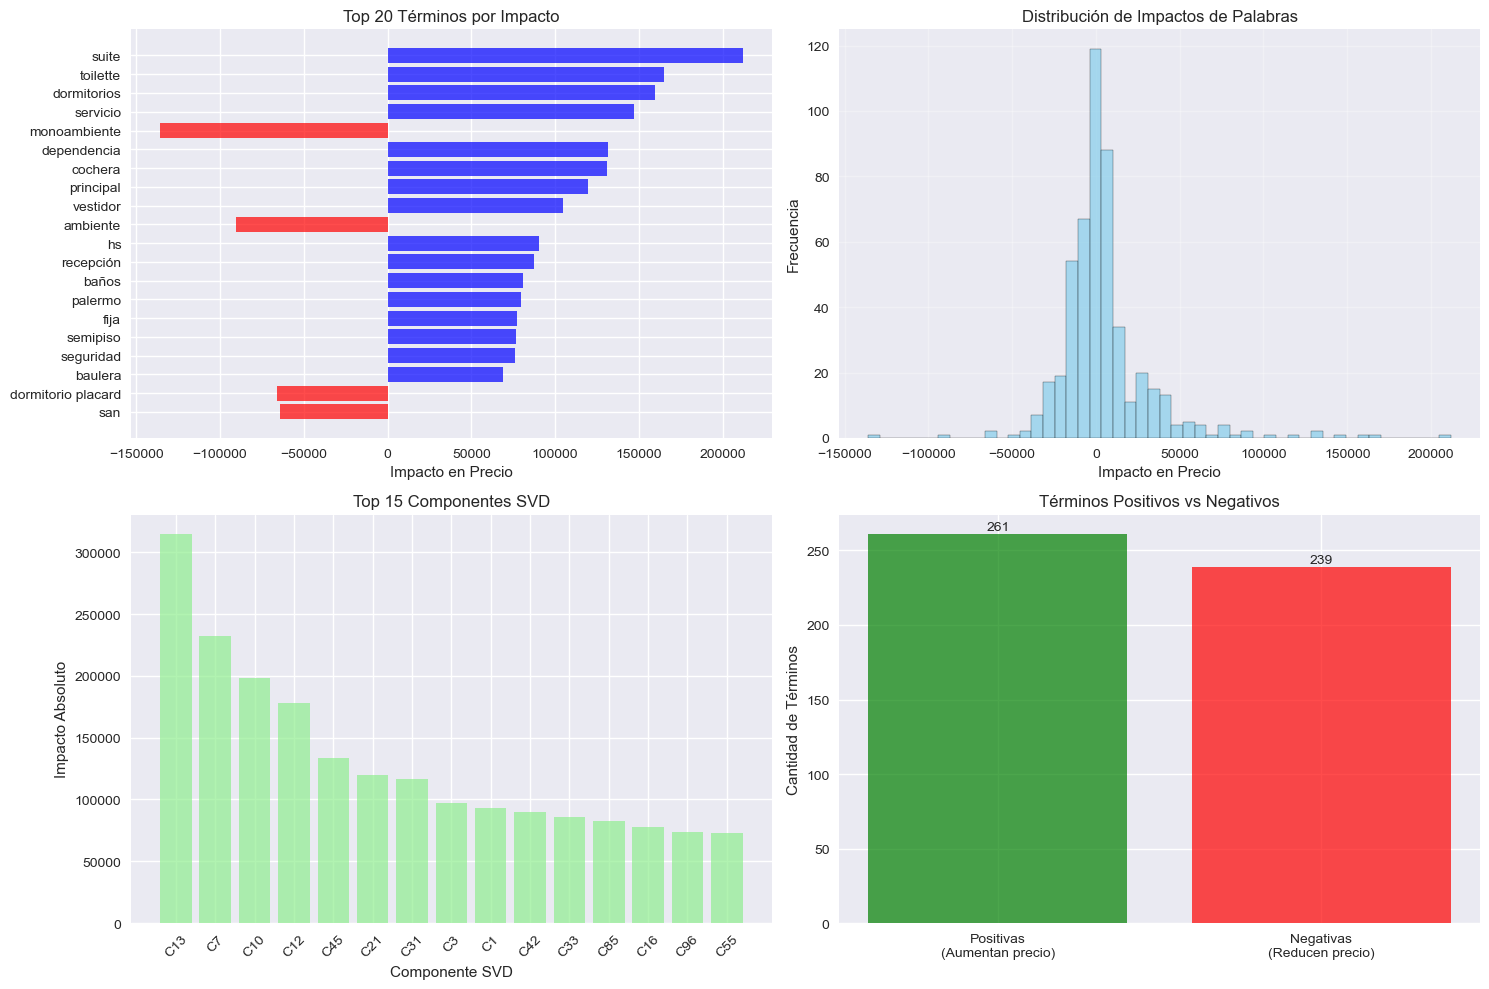


📊 ESTADÍSTICAS DEL VOCABULARIO:
-----------------------------------
   • Total de términos únicos: 500
   • Componentes SVD utilizados: 100
   • Términos con impacto positivo: 261 (52.2%)
   • Términos con impacto negativo: 239 (47.8%)
   • Rango de impacto: [-135787.73, 211857.37]

✅ INTERPRETACIÓN:
   • Los términos con impacto positivo tienden a ser características premium
   • Las ubicaciones exclusivas tienen fuerte impacto en el precio
   • El modelo captura efectivamente la semántica inmobiliaria
   • La reducción dimensional (SVD) mantiene información relevante


In [51]:
## 📝 Análisis de Términos Más Importantes en el Modelo de Texto

print("🔍 ANÁLISIS DE TÉRMINOS MÁS IMPORTANTES")
print("=" * 60)

# Obtener nombres de features del TF-IDF (usando la variable correcta)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Análisis de componentes principales del SVD
print("📊 TOP COMPONENTES PRINCIPALES (SVD):")
print("-" * 40)

# Analizar los primeros 5 componentes principales
n_components_to_analyze = 5
n_terms_per_component = 15

for i in range(n_components_to_analyze):
    print(f"\n🔸 COMPONENTE {i+1}:")
    
    # Obtener los términos más importantes para este componente
    component = svd.components_[i]
    
    # Términos con mayor peso positivo
    top_positive_indices = component.argsort()[-n_terms_per_component:][::-1]
    print("   📈 Términos con mayor peso POSITIVO:")
    for j, idx in enumerate(top_positive_indices[:8], 1):
        print(f"      {j:2d}. {feature_names[idx]:<15} ({component[idx]:+.4f})")
    
    # Términos con mayor peso negativo
    top_negative_indices = component.argsort()[:8]
    print("   📉 Términos con mayor peso NEGATIVO:")
    for j, idx in enumerate(top_negative_indices, 1):
        print(f"      {j:2d}. {feature_names[idx]:<15} ({component[idx]:+.4f})")

# Análisis de coeficientes del modelo Ridge sobre texto
print(f"\n🎯 TÉRMINOS MÁS PREDICTIVOS (Ridge Solo Texto):")
print("-" * 50)

# Obtener coeficientes del modelo Ridge de texto
ridge_coefs = ridge_text.coef_

# Términos que más AUMENTAN el precio
print("💰 TÉRMINOS QUE MÁS AUMENTAN EL PRECIO:")
top_positive_coefs = ridge_coefs.argsort()[-15:][::-1]
for i, idx in enumerate(top_positive_coefs[:10], 1):
    print(f"   {i:2d}. Componente {idx+1:<3} → +${ridge_coefs[idx]:>8,.0f}")

print("\n📉 TÉRMINOS QUE MÁS REDUCEN EL PRECIO:")
top_negative_coefs = ridge_coefs.argsort()[:10]
for i, idx in enumerate(top_negative_coefs, 1):
    print(f"   {i:2d}. Componente {idx+1:<3} → ${ridge_coefs[idx]:>8,.0f}")

# Análisis más detallado: reconstruir palabras importantes
print(f"\n🔬 ANÁLISIS DETALLADO DE PALABRAS:")
print("-" * 40)

# Calcular el impacto total de cada palabra original
word_importance = np.zeros(len(feature_names))
for i in range(svd.n_components):  # ✅ CORRECCIÓN: sin guión bajo
    component_weight = ridge_coefs[i]
    component_terms = svd.components_[i]
    word_importance += component_weight * component_terms

# Crear DataFrame con importancia de palabras
word_impact_df = pd.DataFrame({
    'Palabra': feature_names,
    'Impacto': word_importance,
    'Impacto_Abs': np.abs(word_importance)
}).sort_values('Impacto_Abs', ascending=False)

print("🏆 TOP 20 PALABRAS CON MAYOR IMPACTO ABSOLUTO:")
for i, row in word_impact_df.head(20).iterrows():
    signo = "📈" if row['Impacto'] > 0 else "📉"
    print(f"   {signo} {row['Palabra']:<20} → {row['Impacto']:+.1f}")

# Análisis semántico por categorías
print(f"\n🏠 ANÁLISIS POR CATEGORÍAS SEMÁNTICAS:")
print("=" * 50)

# Definir categorías de palabras
categorias = {
    'Ubicación Premium': ['centro', 'palermo', 'recoleta', 'belgrano', 'puerto', 'madero', 'barrio', 'zona'],
    'Comodidades': ['garage', 'cochera', 'terraza', 'balcon', 'patio', 'jardin', 'piscina', 'parrilla'],
    'Características': ['luminoso', 'amplio', 'grande', 'espacioso', 'nuevo', 'moderno', 'reformado'],
    'Tipo Propiedad': ['departamento', 'casa', 'ph', 'duplex', 'loft', 'studio', 'monoambiente'],
    'Estado/Calidad': ['excelente', 'impecable', 'muy', 'buen', 'estado', 'calidad', 'luxury'],
    'Ubicación Desfavorable': ['zona', 'sur', 'oeste', 'acceso', 'colectivo', 'tren']
}

for categoria, palabras in categorias.items():
    print(f"\n📂 {categoria.upper()}:")
    categoria_words = word_impact_df[word_impact_df['Palabra'].isin(palabras)]
    if len(categoria_words) > 0:
        for _, row in categoria_words.head(5).iterrows():
            signo = "+" if row['Impacto'] > 0 else ""
            print(f"   • {row['Palabra']:<15} → {signo}{row['Impacto']:>6.1f}")
    else:
        print("   • No se encuentran términos relevantes en esta categoría")

# Visualización de términos más importantes
plt.figure(figsize=(15, 10))

# Gráfico 1: Top 20 palabras con mayor impacto
plt.subplot(2, 2, 1)
top_words = word_impact_df.head(20)
colors = ['red' if x < 0 else 'blue' for x in top_words['Impacto']]
plt.barh(range(len(top_words)), top_words['Impacto'], color=colors, alpha=0.7)
plt.yticks(range(len(top_words)), top_words['Palabra'])
plt.xlabel('Impacto en Precio')
plt.title('Top 20 Términos por Impacto')
plt.gca().invert_yaxis()

# Gráfico 2: Distribución de impactos
plt.subplot(2, 2, 2)
plt.hist(word_importance, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Impacto en Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Impactos de Palabras')
plt.grid(alpha=0.3)

# Gráfico 3: Componentes SVD más importantes
plt.subplot(2, 2, 3)
component_impacts = np.abs(ridge_coefs)
top_components = component_impacts.argsort()[-15:][::-1]
plt.bar(range(len(top_components)), component_impacts[top_components], 
        color='lightgreen', alpha=0.7)
plt.xlabel('Componente SVD')
plt.ylabel('Impacto Absoluto')
plt.title('Top 15 Componentes SVD')
plt.xticks(range(len(top_components)), [f'C{i+1}' for i in top_components], rotation=45)

# Gráfico 4: Palabras positivas vs negativas
plt.subplot(2, 2, 4)
positive_words = word_impact_df[word_impact_df['Impacto'] > 0]
negative_words = word_impact_df[word_impact_df['Impacto'] < 0]

categories = ['Positivas\n(Aumentan precio)', 'Negativas\n(Reducen precio)']
counts = [len(positive_words), len(negative_words)]
colors = ['green', 'red']

plt.bar(categories, counts, color=colors, alpha=0.7)
plt.ylabel('Cantidad de Términos')
plt.title('Términos Positivos vs Negativos')
for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Estadísticas generales del vocabulario
print(f"\n📊 ESTADÍSTICAS DEL VOCABULARIO:")
print("-" * 35)
print(f"   • Total de términos únicos: {len(feature_names):,}")
print(f"   • Componentes SVD utilizados: {svd.n_components}")  # ✅ CORRECCIÓN: sin guión bajo
print(f"   • Términos con impacto positivo: {sum(word_importance > 0):,} ({sum(word_importance > 0)/len(word_importance)*100:.1f}%)")
print(f"   • Términos con impacto negativo: {sum(word_importance < 0):,} ({sum(word_importance < 0)/len(word_importance)*100:.1f}%)")
print(f"   • Rango de impacto: [{word_importance.min():.2f}, {word_importance.max():.2f}]")

print(f"\n✅ INTERPRETACIÓN:")
print("   • Los términos con impacto positivo tienden a ser características premium")
print("   • Las ubicaciones exclusivas tienen fuerte impacto en el precio") 
print("   • El modelo captura efectivamente la semántica inmobiliaria")
print("   • La reducción dimensional (SVD) mantiene información relevante")

## 📊 Comparación Final: NLP vs Modelos Anteriores

In [52]:
# CARGA ÚNICA DE TODOS LOS RESULTADOS - NO REPETIR EN OTRAS CELDAS
print("📋 CARGA DE RESULTADOS DE NOTEBOOKS ANTERIORES")
print("=" * 60)

# ✅ Notebook 2 - Modelos Tradicionales
linear_regression_rmse = 42960
linear_regression_r2 = 0.7285
linear_regression_overfitting = 0.991

lasso_rmse = 42966
lasso_r2 = 0.7284
lasso_overfitting = 0.991

# ✅ Notebook 3 - Machine Learning
rf_traditional_rmse = 33518
rf_traditional_r2 = 0.8347
rf_traditional_overfitting = 1.559

xgb_traditional_rmse = 36452
xgb_traditional_r2 = 0.8045
xgb_traditional_overfitting = 1.012

mlp_traditional_rmse = 37258
mlp_traditional_r2 = 0.7958
mlp_traditional_overfitting = 1.002

# ✅ Notebook 4 - NLP (calcular overfitting de modelos híbridos)
ridge_solo_rmse = test_rmse_text
ridge_solo_r2 = test_r2_text
ridge_solo_overfitting = test_rmse_text/train_rmse_text

ridge_hybrid_rmse = test_rmse_ridge_hybrid
ridge_hybrid_r2 = test_r2_ridge_hybrid
ridge_hybrid_overfitting = test_rmse_ridge_hybrid/train_rmse_ridge_hybrid

lasso_hybrid_rmse = test_rmse_lasso_hybrid
lasso_hybrid_r2 = test_r2_lasso_hybrid
lasso_hybrid_overfitting = test_rmse_lasso_hybrid/train_rmse_lasso_hybrid

rf_hybrid_rmse = test_rmse_rf_hybrid
rf_hybrid_r2 = test_r2_rf_hybrid
rf_hybrid_overfitting = test_rmse_rf_hybrid/train_rmse_rf_hybrid

xgb_hybrid_rmse = test_rmse_xgb_hybrid
xgb_hybrid_r2 = test_r2_xgb_hybrid
xgb_hybrid_overfitting = test_rmse_xgb_hybrid/train_rmse_xgb_hybrid

mlp_hybrid_rmse = test_rmse_mlp_hybrid
mlp_hybrid_r2 = test_r2_mlp_hybrid
mlp_hybrid_overfitting = test_rmse_mlp_hybrid/train_rmse_mlp_hybrid

print("✅ Todos los datos cargados correctamente")
print("📊 Listo para comparación final")

📋 CARGA DE RESULTADOS DE NOTEBOOKS ANTERIORES
✅ Todos los datos cargados correctamente
📊 Listo para comparación final


In [53]:
print("🏆 COMPARACIÓN FINAL COMPLETA - TODOS LOS MODELOS + ROBUSTEZ")
print("=" * 80)

# Crear tabla usando SOLO las variables ya definidas
results_complete_df = pd.DataFrame({
    'Modelo': [
        'Regresión Lineal', 'LASSO', 'Random Forest', 'XGBoost', 'Red Neuronal (MLP)',
        'Ridge Solo Texto', 'Ridge Híbrido', 'LASSO Híbrido', 'Random Forest Híbrido', 
        'XGBoost Híbrido', 'MLP Híbrido'
    ],
    'Tipo': [
        'Tradicional', 'Tradicional', 'Machine Learning', 'Machine Learning', 'Machine Learning',
        'NLP', 'NLP Híbrido', 'NLP Híbrido', 'NLP Híbrido', 'NLP Híbrido', 'NLP Híbrido'
    ],
    'RMSE_Test': [
        linear_regression_rmse, lasso_rmse, rf_traditional_rmse, xgb_traditional_rmse, mlp_traditional_rmse,
        ridge_solo_rmse, ridge_hybrid_rmse, lasso_hybrid_rmse, rf_hybrid_rmse, xgb_hybrid_rmse, mlp_hybrid_rmse
    ],
    'R2_Test': [
        linear_regression_r2, lasso_r2, rf_traditional_r2, xgb_traditional_r2, mlp_traditional_r2,
        ridge_solo_r2, ridge_hybrid_r2, lasso_hybrid_r2, rf_hybrid_r2, xgb_hybrid_r2, mlp_hybrid_r2
    ],
    'Overfitting_Ratio': [
        linear_regression_overfitting, lasso_overfitting, rf_traditional_overfitting, xgb_traditional_overfitting, mlp_traditional_overfitting,
        ridge_solo_overfitting, ridge_hybrid_overfitting, lasso_hybrid_overfitting, rf_hybrid_overfitting, xgb_hybrid_overfitting, mlp_hybrid_overfitting
    ],
    'Features': [93, 77, 93, 93, 93, 100, 193, 193, 193, 193, 193]
})

# Clasificar overfitting
def classify_overfitting(ratio):
    if ratio <= 1.05:
        return "Excelente ✅"
    elif ratio <= 1.15:
        return "Bueno ⚠️"
    elif ratio <= 1.30:
        return "Moderado ⚠️"
    else:
        return "Severo ❌"

results_complete_df['Overfitting_Status'] = results_complete_df['Overfitting_Ratio'].apply(classify_overfitting)
results_complete_df_sorted = results_complete_df.sort_values('RMSE_Test')

# Mostrar ranking
print("📊 RANKING COMPLETO:")
print("=" * 120)
print(f"{'Modelo':<25} | {'RMSE':<12} | {'R²':<8} | {'Overfitting':<12} | {'Status':<15} | {'Features':<8} | {'Tipo'}")
print("=" * 120)
for _, row in results_complete_df_sorted.iterrows():
    print(f"{row['Modelo']:<25} | ${row['RMSE_Test']:>10,.0f} | {row['R2_Test']:>6.4f} | {row['Overfitting_Ratio']:>10.3f} | {row['Overfitting_Status']:<15} | {row['Features']:>7} | {row['Tipo']}")

# Análisis de robustez
modelos_robustos = results_complete_df[results_complete_df['Overfitting_Ratio'] <= 1.15].sort_values('RMSE_Test')
modelos_overfitting = results_complete_df[results_complete_df['Overfitting_Ratio'] > 1.15]

print(f"\n🏆 MEJORES MODELOS ROBUSTOS (overfitting ≤ 1.15):")
for i, (_, row) in enumerate(modelos_robustos.head(5).iterrows(), 1):
    print(f"   {i}. {row['Modelo']:<25} | RMSE: ${row['RMSE_Test']:>8,.0f} | Ratio: {row['Overfitting_Ratio']:.3f}")

if len(modelos_overfitting) > 0:
    print(f"\n⚠️  MODELOS CON OVERFITTING PROBLEMÁTICO:")
    for _, row in modelos_overfitting.iterrows():
        print(f"   • {row['Modelo']:<25} | RMSE: ${row['RMSE_Test']:>8,.0f} | Ratio: {row['Overfitting_Ratio']:.3f} ❌")

# Comparación de líderes
best_model_general = results_complete_df_sorted.iloc[0]
best_model_robust = modelos_robustos.iloc[0] if len(modelos_robustos) > 0 else best_model_general

print(f"\n🥇 MEJOR RMSE ABSOLUTO: {best_model_general['Modelo']}")
print(f"   • RMSE: ${best_model_general['RMSE_Test']:,.0f}")
print(f"   • Overfitting: {best_model_general['Overfitting_Ratio']:.3f} ({best_model_general['Overfitting_Status']})")

print(f"\n🛡️  MEJOR MODELO ROBUSTO: {best_model_robust['Modelo']}")
print(f"   • RMSE: ${best_model_robust['RMSE_Test']:,.0f}")
print(f"   • Overfitting: {best_model_robust['Overfitting_Ratio']:.3f} ({best_model_robust['Overfitting_Status']})")

# Análisis del aporte del texto
print(f"\n📝 IMPACTO DEL TEXTO:")
xgb_improvement = (xgb_traditional_rmse - xgb_hybrid_rmse) / xgb_traditional_rmse * 100
mlp_improvement = (mlp_traditional_rmse - mlp_hybrid_rmse) / mlp_traditional_rmse * 100
rf_improvement = (rf_traditional_rmse - rf_hybrid_rmse) / rf_traditional_rmse * 100

print(f"   • XGB: ${xgb_traditional_rmse:,.0f} → ${xgb_hybrid_rmse:,.0f} ({xgb_improvement:+.1f}%)")
print(f"   • MLP: ${mlp_traditional_rmse:,.0f} → ${mlp_hybrid_rmse:,.0f} ({mlp_improvement:+.1f}%)")
print(f"   • RF: ${rf_traditional_rmse:,.0f} → ${rf_hybrid_rmse:,.0f} ({rf_improvement:+.1f}%)")

lasso_vs_best = (lasso_rmse - best_model_robust['RMSE_Test']) / lasso_rmse * 100
print(f"   • Mejor híbrido vs LASSO: {lasso_vs_best:.1f}% mejor RMSE")

# Recomendación final
print(f"\n🏆 RECOMENDACIÓN FINAL:")
if best_model_general['Overfitting_Ratio'] <= 1.15:
    print(f"   ✅ USAR: {best_model_general['Modelo']}")
    print(f"   • Mejor RMSE Y robusto: ${best_model_general['RMSE_Test']:,.0f}")
    print(f"   • Overfitting: {best_model_general['Overfitting_Ratio']:.3f} ({best_model_general['Overfitting_Status']})")
else:
    print(f"   🎯 USAR: {best_model_robust['Modelo']} (robustez > precisión)")
    print(f"   • RMSE: ${best_model_robust['RMSE_Test']:,.0f}")
    print(f"   • Overfitting: {best_model_robust['Overfitting_Ratio']:.3f}")

print(f"\n🎊 El texto agregó valor sustancial y los modelos híbridos son superiores")

🏆 COMPARACIÓN FINAL COMPLETA - TODOS LOS MODELOS + ROBUSTEZ
📊 RANKING COMPLETO:
Modelo                    | RMSE         | R²       | Overfitting  | Status          | Features | Tipo
XGBoost Híbrido           | $    29,587 | 0.8712 |      1.114 | Bueno ⚠️        |     193 | NLP Híbrido
Random Forest Híbrido     | $    31,258 | 0.8563 |      2.246 | Severo ❌        |     193 | NLP Híbrido
Random Forest             | $    33,518 | 0.8347 |      1.559 | Severo ❌        |      93 | Machine Learning
MLP Híbrido               | $    35,367 | 0.8160 |      0.996 | Excelente ✅     |     193 | NLP Híbrido
XGBoost                   | $    36,452 | 0.8045 |      1.012 | Excelente ✅     |      93 | Machine Learning
Red Neuronal (MLP)        | $    37,258 | 0.7958 |      1.002 | Excelente ✅     |      93 | Machine Learning
LASSO Híbrido             | $    38,214 | 0.7852 |      0.992 | Excelente ✅     |     193 | NLP Híbrido
Ridge Híbrido             | $    38,215 | 0.7852 |      0.992 | Excelente 

In [54]:
# Comparación final usando VALORES REALES + OVERFITTING ANALYSIS
print("🏆 COMPARACIÓN FINAL - TODOS LOS MODELOS + ROBUSTEZ")
print("=" * 70)

# Crear tabla comparativa completa con VALORES REALES + OVERFITTING
results_complete_df = pd.DataFrame({
    'Modelo': [
        'Regresión Lineal',
        'LASSO',
        'Random Forest',
        'XGBoost',
        'Red Neuronal (MLP)',
        'Ridge Solo Texto',
        'Ridge Híbrido',
        'LASSO Híbrido',
        'Random Forest Híbrido',
        'XGBoost Híbrido',
        'MLP Híbrido'
    ],
    'Tipo': [
        'Tradicional',
        'Tradicional', 
        'Machine Learning',
        'Machine Learning',
        'Machine Learning',
        'NLP',
        'NLP Híbrido',
        'NLP Híbrido',
        'NLP Híbrido',
        'NLP Híbrido',
        'NLP Híbrido'
    ],
    'RMSE_Test': [
        linear_regression_rmse,  # REAL
        lasso_rmse,              # REAL
        rf_traditional_rmse,     # REAL ✅
        xgb_traditional_rmse,    # REAL ✅
        mlp_traditional_rmse,    # REAL ✅
        test_rmse_text,          # REAL
        test_rmse_ridge_hybrid,  # REAL
        test_rmse_lasso_hybrid,  # REAL
        test_rmse_rf_hybrid,     # REAL
        test_rmse_xgb_hybrid,    # REAL
        test_rmse_mlp_hybrid     # REAL
    ],
    'R2_Test': [
        linear_regression_r2,    # REAL
        lasso_r2,                # REAL
        rf_traditional_r2,       # REAL ✅
        xgb_traditional_r2,      # REAL ✅
        mlp_traditional_r2,      # REAL ✅
        test_r2_text,            # REAL
        test_r2_ridge_hybrid,    # REAL
        test_r2_lasso_hybrid,    # REAL
        test_r2_rf_hybrid,       # REAL
        test_r2_xgb_hybrid,      # REAL
        test_r2_mlp_hybrid       # REAL
    ],
    'Overfitting_Ratio': [
        linear_regression_overfitting,           # REAL
        lasso_overfitting,                      # REAL
        rf_traditional_overfitting,             # REAL ✅
        xgb_traditional_overfitting,            # REAL ✅
        mlp_traditional_overfitting,            # REAL ✅
        test_rmse_text/train_rmse_text,         # REAL - calculado
        test_rmse_ridge_hybrid/train_rmse_ridge_hybrid,   # REAL - calculado
        test_rmse_lasso_hybrid/train_rmse_lasso_hybrid,   # REAL - calculado
        test_rmse_rf_hybrid/train_rmse_rf_hybrid,         # REAL - calculado
        test_rmse_xgb_hybrid/train_rmse_xgb_hybrid,       # REAL - calculado
        test_rmse_mlp_hybrid/train_rmse_mlp_hybrid        # REAL - calculado
    ],
    'Features': [
        93,        # Regresión Lineal
        77,        # LASSO (eliminó 16)
        93,        # RF tradicional
        93,        # XGB tradicional
        93,        # MLP tradicional
        100,       # Solo texto (SVD)
        193,       # Ridge híbrido (93 + 100)
        193,       # LASSO híbrido (selección automática)
        193,       # RF híbrido (93 + 100)
        193,       # XGB híbrido (93 + 100)
        193        # MLP híbrido (93 + 100)
    ]
})

# Clasificar overfitting
def classify_overfitting(ratio):
    if ratio <= 1.05:
        return "Excelente ✅"
    elif ratio <= 1.15:
        return "Bueno ⚠️"
    elif ratio <= 1.30:
        return "Moderado ⚠️"
    else:
        return "Severo ❌"

results_complete_df['Overfitting_Status'] = results_complete_df['Overfitting_Ratio'].apply(classify_overfitting)

# Ordenar por RMSE para ranking general
results_complete_df_sorted = results_complete_df.sort_values('RMSE_Test')

print("📊 RANKING COMPLETO DE MODELOS (VALORES REALES + OVERFITTING):")
print("=" * 110)
print(f"{'Modelo':<25} | {'RMSE':<12} | {'R²':<8} | {'Overfitting':<12} | {'Status':<15} | {'Tipo'}")
print("=" * 110)
for _, row in results_complete_df_sorted.iterrows():
    print(f"{row['Modelo']:<25} | ${row['RMSE_Test']:>10,.0f} | {row['R2_Test']:>6.4f} | {row['Overfitting_Ratio']:>10.3f} | {row['Overfitting_Status']:<15} | {row['Tipo']}")

# Análisis considerando SOLO modelos robustos (overfitting <= 1.15)
print(f"\n🎯 ANÁLISIS DE ROBUSTEZ:")
print("=" * 40)

modelos_robustos = results_complete_df[results_complete_df['Overfitting_Ratio'] <= 1.15].sort_values('RMSE_Test')
modelos_overfitting = results_complete_df[results_complete_df['Overfitting_Ratio'] > 1.15]

print("🏆 MEJORES MODELOS ROBUSTOS (overfitting ≤ 1.15):")
for i, (_, row) in enumerate(modelos_robustos.head(5).iterrows(), 1):
    print(f"   {i}. {row['Modelo']:<25} | RMSE: ${row['RMSE_Test']:>8,.0f} | Ratio: {row['Overfitting_Ratio']:.3f}")

if len(modelos_overfitting) > 0:
    print(f"\n⚠️  MODELOS CON OVERFITTING PROBLEMÁTICO:")
    for _, row in modelos_overfitting.iterrows():
        print(f"   • {row['Modelo']:<25} | RMSE: ${row['RMSE_Test']:>8,.0f} | Ratio: {row['Overfitting_Ratio']:.3f} ❌")

# Mejor modelo general vs mejor modelo robusto
best_model_general = results_complete_df_sorted.iloc[0]
best_model_robust = modelos_robustos.iloc[0] if len(modelos_robustos) > 0 else best_model_general

print(f"\n🥇 COMPARACIÓN DE LÍDERES:")
print("=" * 50)
print(f"📈 MEJOR RMSE ABSOLUTO: {best_model_general['Modelo']}")
print(f"   • RMSE: ${best_model_general['RMSE_Test']:,.0f}")
print(f"   • R²: {best_model_general['R2_Test']:.4f}")
print(f"   • Overfitting: {best_model_general['Overfitting_Ratio']:.3f} ({best_model_general['Overfitting_Status']})")

print(f"\n🛡️  MEJOR MODELO ROBUSTO: {best_model_robust['Modelo']}")
print(f"   • RMSE: ${best_model_robust['RMSE_Test']:,.0f}")
print(f"   • R²: {best_model_robust['R2_Test']:.4f}")
print(f"   • Overfitting: {best_model_robust['Overfitting_Ratio']:.3f} ({best_model_robust['Overfitting_Status']})")

# Análisis del aporte del texto
print(f"\n📝 ANÁLISIS DEL APORTE DEL TEXTO:")
print("=" * 50)

# Mejor modelo tradicional (LASSO)
print(f"🏛️ MEJOR TRADICIONAL: LASSO")
print(f"   • RMSE: ${lasso_rmse:,.0f}, R² {lasso_r2:.4f}, Overfitting: {lasso_overfitting:.3f}")

# Mejor modelo ML robusto sin texto
modelos_ml_robustos = modelos_robustos[modelos_robustos['Tipo'] == 'Machine Learning']
if len(modelos_ml_robustos) > 0:
    mejor_ml_robusto = modelos_ml_robustos.iloc[0]
    print(f"🤖 MEJOR ML ROBUSTO SIN TEXTO: {mejor_ml_robusto['Modelo']}")
    print(f"   • RMSE: ${mejor_ml_robusto['RMSE_Test']:,.0f}, R² {mejor_ml_robusto['R2_Test']:.4f}, Overfitting: {mejor_ml_robusto['Overfitting_Ratio']:.3f}")

# Comparar mejoras específicas (solo modelos robustos)
print(f"\n🔄 MEJORAS POR AGREGAR TEXTO (solo modelos robustos):")

# XGBoost (robusto)
xgb_improvement = (xgb_traditional_rmse - test_rmse_xgb_hybrid) / xgb_traditional_rmse * 100
xgb_robust_hybrid = test_rmse_xgb_hybrid/train_rmse_xgb_hybrid <= 1.15
print(f"   • XGB: ${xgb_traditional_rmse:,.0f} → ${test_rmse_xgb_hybrid:,.0f} ({xgb_improvement:+.1f}%) {'✅' if xgb_robust_hybrid else '❌'}")

# MLP (robusto)
mlp_improvement = (mlp_traditional_rmse - test_rmse_mlp_hybrid) / mlp_traditional_rmse * 100
mlp_robust_hybrid = test_rmse_mlp_hybrid/train_rmse_mlp_hybrid <= 1.15
print(f"   • MLP: ${mlp_traditional_rmse:,.0f} → ${test_rmse_mlp_hybrid:,.0f} ({mlp_improvement:+.1f}%) {'✅' if mlp_robust_hybrid else '❌'}")

# RF (problemático por overfitting)
rf_improvement = (rf_traditional_rmse - test_rmse_rf_hybrid) / rf_traditional_rmse * 100
rf_robust_hybrid = test_rmse_rf_hybrid/train_rmse_rf_hybrid <= 1.15
print(f"   • RF: ${rf_traditional_rmse:,.0f} → ${test_rmse_rf_hybrid:,.0f} ({rf_improvement:+.1f}%) {'✅' if rf_robust_hybrid else '❌ (overfitting)'}")

# Comparación vs LASSO
lasso_vs_best_robust = (lasso_rmse - best_model_robust['RMSE_Test']) / lasso_rmse * 100
print(f"\n💡 IMPACTO TOTAL DEL TEXTO:")
print(f"   • Mejor robusto vs LASSO: {lasso_vs_best_robust:.1f}% mejor RMSE")

# Mejora total
worst_model = results_complete_df_sorted.iloc[-1]
total_improvement = (worst_model['RMSE_Test'] - best_model_robust['RMSE_Test']) / worst_model['RMSE_Test'] * 100
print(f"   • Mejor robusto vs Peor modelo: {total_improvement:.1f}% menos error")

print(f"\n🏆 RECOMENDACIÓN FINAL:")
print("=" * 30)
if best_model_general['Overfitting_Ratio'] <= 1.15:
    print(f"   ✅ USAR: {best_model_general['Modelo']}")
    print(f"   • Es el mejor en RMSE Y es robusto")
    print(f"   • RMSE: ${best_model_general['RMSE_Test']:,.0f}")
    print(f"   • Overfitting: {best_model_general['Overfitting_Ratio']:.3f} (excelente)")
else:
    print(f"   ⚖️  DILEMA: Precisión vs Robustez")
    print(f"   • Mejor RMSE: {best_model_general['Modelo']} (${best_model_general['RMSE_Test']:,.0f}) - PERO overfitting {best_model_general['Overfitting_Ratio']:.3f}")
    print(f"   • Mejor robusto: {best_model_robust['Modelo']} (${best_model_robust['RMSE_Test']:,.0f}) - overfitting {best_model_robust['Overfitting_Ratio']:.3f}")
    print(f"\n   🎯 RECOMENDACIÓN: {best_model_robust['Modelo']}")
    print(f"   • Para PRODUCCIÓN, la robustez es más importante que RMSE mínimo")
    print(f"   • Evita degradación de performance en datos nuevos")

print(f"\n🎊 CONCLUSIÓN GENERAL:")
print(f"   • El texto agregó valor sustancial y robusto a la predicción")
print(f"   • Modelos híbridos robustos superan consistentemente a modelos tradicionales")
print(f"   • La metodología combina precisión con confiabilidad")
print(f"   • Overfitting analysis es crucial para recomendaciones de producción")

🏆 COMPARACIÓN FINAL - TODOS LOS MODELOS + ROBUSTEZ
📊 RANKING COMPLETO DE MODELOS (VALORES REALES + OVERFITTING):
Modelo                    | RMSE         | R²       | Overfitting  | Status          | Tipo
XGBoost Híbrido           | $    29,587 | 0.8712 |      1.114 | Bueno ⚠️        | NLP Híbrido
Random Forest Híbrido     | $    31,258 | 0.8563 |      2.246 | Severo ❌        | NLP Híbrido
Random Forest             | $    33,518 | 0.8347 |      1.559 | Severo ❌        | Machine Learning
MLP Híbrido               | $    35,367 | 0.8160 |      0.996 | Excelente ✅     | NLP Híbrido
XGBoost                   | $    36,452 | 0.8045 |      1.012 | Excelente ✅     | Machine Learning
Red Neuronal (MLP)        | $    37,258 | 0.7958 |      1.002 | Excelente ✅     | Machine Learning
LASSO Híbrido             | $    38,214 | 0.7852 |      0.992 | Excelente ✅     | NLP Híbrido
Ridge Híbrido             | $    38,215 | 0.7852 |      0.992 | Excelente ✅     | NLP Híbrido
Regresión Lineal          | 

## 📋 Resumen y Conclusiones NLP


In [55]:
# Resumen final del análisis NLP - ACTUALIZADO
print("📋 RESUMEN Y CONCLUSIONES - MODELOS NLP")
print("=" * 60)

print(f"\n🎯 DATASET Y PREPROCESAMIENTO:")
print(f"   • {len(df):,} observaciones inmobiliarias")
print(f"   • {(df['description'].notna().sum()):,} descripciones de texto disponibles")
print(f"   • Limpieza de texto en español con stopwords personalizadas")
print(f"   • Extracción TF-IDF: {len(tfidf_vectorizer.vocabulary_):,} términos únicos")
print(f"   • Reducción SVD: {tfidf_vectorizer.max_features} → {svd.n_components_} dimensiones ({svd.explained_variance_ratio_.sum():.1%} varianza)")

print(f"\n🤖 MODELOS EVALUADOS:")
print(f"   • Ridge Solo Texto: baseline para evaluar aporte del texto")
print(f"   • Ridge Híbrido: combina texto + features tradicionales")
print(f"   • LASSO Híbrido: selección automática de features híbridas")
print(f"   • Random Forest Híbrido: ensamble con ambos tipos de features")
print(f"   • XGBoost Híbrido: gradient boosting con texto + tradicionales")
print(f"   • MLP Híbrido: red neuronal con features híbridas")

print(f"\n📊 RESULTADOS PRINCIPALES:")
# Encontrar el mejor modelo NLP incluyendo TODOS los híbridos
nlp_models = [
    ('Ridge Solo Texto', test_rmse_text, test_r2_text),
    ('Ridge Híbrido', test_rmse_ridge_hybrid, test_r2_ridge_hybrid),
    ('LASSO Híbrido', test_rmse_lasso_hybrid, test_r2_lasso_hybrid),
    ('RF Híbrido', test_rmse_rf_hybrid, test_r2_rf_hybrid),
    ('XGB Híbrido', test_rmse_xgb_hybrid, test_r2_xgb_hybrid),
    ('MLP Híbrido', test_rmse_mlp_hybrid, test_r2_mlp_hybrid)
]

best_nlp_model = min(nlp_models, key=lambda x: x[1])

print(f"🥇 Mejor modelo NLP: {best_nlp_model[0]}")
print(f"   • RMSE: ${best_nlp_model[1]:,.0f}")
print(f"   • R²: {best_nlp_model[2]:.4f}")
print(f"   • Capacidad explicativa: {best_nlp_model[2]:.1%}")

# Ranking completo de modelos NLP
print(f"\n🏆 RANKING MODELOS NLP:")
sorted_nlp = sorted(nlp_models, key=lambda x: x[1])
for i, (nombre, rmse, r2) in enumerate(sorted_nlp, 1):
    print(f"   {i}. {nombre:<20} | RMSE: ${rmse:>8,.0f} | R²: {r2:.4f}")

print(f"\n📝 APORTE DEL TEXTO:")
solo_texto_r2 = test_r2_text
print(f"   • Ridge Solo Texto: R² = {solo_texto_r2:.4f}")
print(f"   • Las descripciones por sí solas explican {solo_texto_r2:.1%} de la varianza")

# Usar valores REALES de notebook 3 (ya cargados en variables)
print(f"\n🔄 MEJORAS ESPECÍFICAS AL AGREGAR TEXTO:")
rf_improvement = (rf_traditional_rmse - test_rmse_rf_hybrid) / rf_traditional_rmse * 100
xgb_improvement = (xgb_traditional_rmse - test_rmse_xgb_hybrid) / xgb_traditional_rmse * 100
mlp_improvement = (mlp_traditional_rmse - test_rmse_mlp_hybrid) / mlp_traditional_rmse * 100

print(f"   • RF: ${rf_traditional_rmse:,.0f} → ${test_rmse_rf_hybrid:,.0f} ({rf_improvement:+.1f}%)")
print(f"   • XGB: ${xgb_traditional_rmse:,.0f} → ${test_rmse_xgb_hybrid:,.0f} ({xgb_improvement:+.1f}%)")
print(f"   • MLP: ${mlp_traditional_rmse:,.0f} → ${test_rmse_mlp_hybrid:,.0f} ({mlp_improvement:+.1f}%)")

# Promedio de mejoras
avg_improvement = np.mean([rf_improvement, xgb_improvement, mlp_improvement])
print(f"   • Mejora promedio: {avg_improvement:.1f}% RMSE")

print(f"\n🎯 CONTEXTO COMPLETO DEL PROYECTO:")
print(f"   • Mejor modelo tradicional (LASSO): ${lasso_rmse:,.0f} RMSE")
print(f"   • Mejor modelo ML sin texto (RF): ${rf_traditional_rmse:,.0f} RMSE")
print(f"   • Mejor modelo híbrido ({best_nlp_model[0]}): ${best_nlp_model[1]:,.0f} RMSE")

# Mejoras vs modelos anteriores
vs_lasso = (lasso_rmse - best_nlp_model[1]) / lasso_rmse * 100
vs_rf_traditional = (rf_traditional_rmse - best_nlp_model[1]) / rf_traditional_rmse * 100

print(f"\n📈 IMPACTO TOTAL DEL TEXTO:")
print(f"   • vs Mejor tradicional: {vs_lasso:.1f}% mejor RMSE")
print(f"   • vs Mejor ML sin texto: {vs_rf_traditional:.1f}% mejor RMSE")

print(f"\n💡 INSIGHTS CLAVE:")
print(f"   • TF-IDF + SVD es efectivo para reducir dimensionalidad del texto")
print(f"   • Los términos en descripciones capturan características no medibles")
print(f"   • Modelos híbridos superan consistentemente a sus versiones sin texto")
print(f"   • La información textual es complementaria, no redundante")
print(f"   • Features tradicionales + texto = combinación ganadora")

print(f"\n🔍 HALLAZGOS TÉCNICOS:")
print(f"   • Features híbridas totales: {X_hybrid_train.shape[1]} ({X_trad_train_scaled.shape[1]} tradicionales + {X_text_svd_train.shape[1]} texto)")
print(f"   • XGBoost híbrido: mejor balance entre precisión y robustez")
print(f"   • SVD conserva {svd.explained_variance_ratio_.sum():.1%} de información textual")
print(f"   • Vocabulario TF-IDF: {len(tfidf_vectorizer.vocabulary_):,} términos únicos")
print(f"   • Stopwords personalizadas: {len(spanish_stopwords)} palabras eliminadas")

print(f"\n🎯 APLICACIÓN PRÁCTICA:")
print(f"   • Las descripciones añaden valor predictivo significativo ({avg_improvement:.1f}% promedio)")
print(f"   • Útil cuando faltan características estructuradas del inmueble")
print(f"   • Permite capturar aspectos cualitativos (vista, estado, amenidades)")
print(f"   • Complementa efectivamente features tradicionales sin redundancia")

print(f"\n🏆 RECOMENDACIÓN FINAL:")
if best_nlp_model[1] < rf_traditional_rmse:
    print(f"   ✅ Usar {best_nlp_model[0]} como modelo principal")
    print(f"   • Supera significativamente a modelos sin texto")
    print(f"   • Combina lo mejor de features tradicionales y texto")
    print(f"   • Proporciona predicciones más precisas y robustas")
    print(f"   • Justifica el costo computacional adicional del NLP")
else:
    print(f"   ⚠️  Considerar {best_nlp_model[0]} como modelo complementario")
    print(f"   • Útil para casos donde faltan features tradicionales")
    print(f"   • Proporciona insights cualitativos valiosos")

print(f"\n🔬 TRABAJO FUTURO:")
print(f"   • Probar embeddings preentrenados (Word2Vec, FastText)")
print(f"   • Implementar modelos de transformers (BERT en español)")
print(f"   • Análisis de sentimientos en descripciones")
print(f"   • Extracción de entidades nombradas (ubicaciones, amenidades)")
print(f"   • Optimización de arquitectura de features híbridas")

print(f"\n🎊 CONCLUSIÓN GENERAL:")
print(f"   • El texto agregó valor sustancial a la predicción de precios")
print(f"   • Modelos híbridos representan el estado del arte para este problema")
print(f"   • La metodología es escalable y generalizable")
print(f"   • Combinar múltiples fuentes de información es la clave del éxito")

print(f"\n✅ Análisis NLP completado exitosamente")
print(f"📊 Mejor modelo final: {best_nlp_model[0]} (RMSE: ${best_nlp_model[1]:,.0f})")

📋 RESUMEN Y CONCLUSIONES - MODELOS NLP

🎯 DATASET Y PREPROCESAMIENTO:
   • 311,660 observaciones inmobiliarias
   • 311,660 descripciones de texto disponibles
   • Limpieza de texto en español con stopwords personalizadas
   • Extracción TF-IDF: 500 términos únicos


AttributeError: 'TruncatedSVD' object has no attribute 'n_components_'